In [1]:
# -*- coding:utf-8 -*- ＃
import sys
import time
import networkx as nx
from operator import add
import numpy as np
def buildinginone(l):
    if u"图书馆" in l:
        return u"图书馆"
    if u"工程训练中心" in l:
        return u"工程训练中心"
    if u"新行政楼" in l:
        return u"新行政楼"
    if u"系统生物" in l:
        return u"系统生物"
    if u"航空航天" in l:
        return u"航空航天学院"
    if u"宿舍" in l:
        return "宿舍"
    return l

holiday=['2014-10-01', '2014-10-02', '2014-10-03','2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07','2015-01-01','2015-01-02','2015-01-03']

day=sc.textFile("./place",100).map(lambda x:x.split(",")[0]).distinct().filter(lambda x:x not in holiday)
dl=sorted(day.collect())
data=sc.textFile("./place",100).map(lambda x:x.split(",",2)).map(lambda x:(buildinginone(x[1]),(x[0],x[2]))).groupByKey().mapValues(list)

def tuple2dic(l):
    dic={}
    for i in l:
        if i[0] not in holiday:
            dic[i[0]]=eval(i[1])+dic.get(i[0],[])
    for j in dl:
        l=dic.get(j,[])
        dic[j]=dic.get(j,[])
    return dic
alldaydata=data.mapValues(tuple2dic)

# count=alldaydata.map(lambda x:len(x[1])).distinct()
place=alldaydata.map(lambda x:x[0]).distinct().collect()
datedic={}
for i in dl:
    datedic[i]=str(dl.index(i))
placedic={}
for i in place:
    placedic[i]=str(place.index(i))

def extract_feature(l):
    length=len(l)
    one=0
    two=0
    three=0
    for i in l:
        if i<4:
            three+=1
        if i<3:
            two+=1
        if i<2:
            one+=1
    re=[length,one,two,three]
#     re=list(map(str,re))
    return re
input=alldaydata.flatMapValues(lambda x:x.items())\
                .map(lambda x:((x[0],x[1][0]),x[1][1]))\
                .mapValues(extract_feature)\
                .map(lambda x:((placedic.get(x[0][0]),datedic.get(x[0][1])),x[1]))
input.cache()

l=[]
for i in dl:
    l.append(time.localtime(time.mktime(time.strptime(i,"%Y-%m-%d"))).tm_wday)

act=sc.textFile("./actlist").map(lambda x:x.split("\t"))\
        .map(lambda x:((x[2],x[0].replace("/","-")),1))\
        .map(lambda x:((placedic.get(x[0][0]),datedic.get(x[0][1])),1))
# active list shit shit shti

final=input.leftOuterJoin(act).mapValues(lambda x:x[0]+([1] if x[1]==1 else [0])).map(lambda x:[int(x[0][0])]+[int(x[0][1])]+x[1])

# 分类
one=final.filter(lambda x:x[-1]==1)
no=final.filter(lambda x:x[-1]==0)
one.cache()
no.cache()

PythonRDD[29] at RDD at PythonRDD.scala:48

In [2]:
av=0

In [4]:
import xgboost as xgb
def qua(l):
    n=(len(l)/4)
    re=[]
    re.append(l[:n])
    re.append(l[n:n*2])
    re.append(l[n*2:n*3])
    re.append(l[n*3:])
    return re
no=[]
one=[]
re=[]
f=open("./part-00000",'r')
for i in f:
    no.append(list(map(int,i.split(","))))
f=open("./part-00000 (1)",'r')
for i in f:
    one.append(list(map(int,i.split(","))))
f.close()
al=np.array(no+one)
data=al[:,:-1]
label=al[:,-1]
xgal = xgb.DMatrix( data, label=label)
no=np.array(no)
one=np.array(one)
np.random.shuffle(no)
np.random.shuffle(one)

In [ ]:
auclist=[]
np.random.shuffle(no)
np.random.shuffle(one)
# for i in range(5):
for bb in [1]:
    al=qua(no)
    smallno=no[:(36*bb)]
    re=[]
    nl=qua(smallno)
    ol=qua(one)
    big=0
    right=0
    au=[]
    for i in range(4):
        test=np.row_stack((ol[i],nl[i]))
        train=""
        for j in range(4):
            if j==i:
                continue
            if train=="":
                train=np.row_stack((ol[j],nl[j]))
                continue
            train=np.row_stack((train,nl[j]))
            train=np.row_stack((train,ol[j]))
        t=train
        data=np.array(t)[:,:-1]
        label=np.array(t)[:,-1]
        xgtrain = xgb.DMatrix( data, label=label)
        t=test
        data=np.array(t)[:,:-1]
        label=np.array(t)[:,-1]
        xgtest = xgb.DMatrix( data, label=label)

        params={
        'booster':'gbtree',
        # 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
        'objective': 'binary:logistic', 
        'subsample':1,
        'gamma':0.5,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
        'max_depth':4, # 构建树的深度 [1:]
        'colsample_bytree':0.7, # 构建树树时的采样比率 (0:1]
        'min_child_weight':3,
        'silent':0 ,
        'eta': 0.1, # 如同学习率
        'seed':710,
        'nthread':4,# cpu 线程数,根据自己U的个数适当调整
        'eval_metric':'auc'
        }
        plst = list(params.items())
        #         xgtest=xgal
        watchlist = [(xgtrain, 'train'),(xgtest, 'val')]
        num_rounds=3000
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,early_stopping_rounds=50)
        preds = model.predict(xgtest,ntree_limit=model.best_iteration)
#         hold=(174/bb)/(1+bb)
        hold=1/(1+bb)
        for i in range(len(preds)):
            t=[]
            t.append(xgtest.get_label()[i])
            t.append(preds[i])
            au.append(t)
            if t[0]==1:
                re.append(t[1]) 
            if t[1]>hold:
                big+=1
                if t[0]==1:
                    right+=1
from sklearn.metrics import roc_auc_score
auc=np.array(au)
y = auc[:,0] 
pred =auc[:,1]
av+=(roc_auc_score(y,pred))
print(big)
print(right)
print(sorted(re))
av

In [ ]:
print(roc_auc_score(y,pred))

av

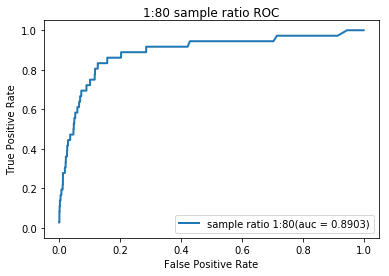

In [354]:
import numpy as np  
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve  
lw = 2

# y = np.array([0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0])   
# pred = np.array([0.1, 0.4, 0.35, 0.28,0.1,0.1,0.7,0.3,0.1, 0.41, 0.35, 0.8,0.32,0.1,0.7,0.3])  
fpr, tpr, thresholds = roc_curve(y, pred)  
# print(fpr)      # array([ 0. ,  0.5,  0.5,  1. ])  
# print(tpr)      # array([ 0.5,  0.5,  1. ,  1. ])  
# print(thresholds)      #array([ 0.8 ,  0.4 ,  0.35,  0.1 ])  

from sklearn.metrics import auc  
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 10)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw,
             label='sample ratio 1:%d(auc = %0.4f)' % ( bb,roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('1:%d sample ratio ROC' % (bb))
plt.legend(loc="lower right")
plt.show()

In [75]:
print(big)
print(right)
print(sorted(re))

8881
133
[0.001856906, 0.0022635702, 0.0028177397, 0.0029285192, 0.0036049043, 0.0053529837, 0.0057674469, 0.0086967042, 0.013449124, 0.015022041, 0.018358709, 0.022962544, 0.024896517, 0.025524419, 0.032167852, 0.033955615, 0.037622567, 0.038688436, 0.041348111, 0.06791646, 0.07312236, 0.078697771, 0.084885187, 0.085981473, 0.086795993, 0.09359587, 0.096546605, 0.097359948, 0.10552026, 0.10564294, 0.11578453, 0.11807193, 0.13114719, 0.1341252, 0.14395894, 0.1582197, 0.16904879, 0.17419335, 0.18372935, 0.19291973, 0.20162097, 0.20306894, 0.22684979, 0.24201031, 0.25136387, 0.2682201, 0.27164638, 0.27164638, 0.27164638, 0.27164638, 0.27164638, 0.28197607, 0.29329067, 0.30112773, 0.30250049, 0.30377784, 0.30437091, 0.30682716, 0.30729237, 0.30937552, 0.31400114, 0.31700259, 0.31837717, 0.3208794, 0.32282585, 0.32645249, 0.33725429, 0.33725429, 0.33725429, 0.34027943, 0.34027943, 0.34027943, 0.3428672, 0.3448793, 0.35288268, 0.3597697, 0.36215344, 0.36721313, 0.3783451, 0.38606241, 0.3928

In [254]:
t=np.arange(16).reshape((4,4))
np.random.shuffle(t)
t

array([[ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3],
       [12, 13, 14, 15]])

In [258]:
t=np.row_stack((t,t))

In [259]:
t

array([[ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3],
       [12, 13, 14, 15],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3],
       [12, 13, 14, 15],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3],
       [12, 13, 14, 15],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3],
       [12, 13, 14, 15]])

In [229]:
np.random.shuffle(t)
t

array([8, 9, 1, 4, 6, 2, 3, 5, 7])

In [223]:
t

array([ 0.        ,  0.02735617], dtype=float32)

In [ ]:
np.random.sample